## Background Information

Now that you are familiar with the portfolio and personal loans and risk are using your model as a guide to loss provisions for the upcoming year, the team now asks you to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. Charlie wants to build a machine learning model that will predict the probability of default, but while you are discussing the methodology, she mentions that the architecture she is using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. She asks if you can find the best way of doing this to allow her to analyze the data.

A FICO score is a standardized credit score created by the Fair Isaac Corporation (FICO) that quantifies the creditworthiness of a borrower to a value between 300 to 850, based on various factors. FICO scores are used in 90% of mortgage application decisions in the United States. The risk manager provides you with FICO scores for the borrowers in the bank’s portfolio and wants you to construct a technique for predicting the PD (probability of default) for the borrowers using these scores. 

## Problem
Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data. You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("Task 3 and 4_Loan_Data.csv")
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


According to https://www.myfico.com/credit-education/what-is-a-fico-score, we can bin the FICO scores as such:
- <580 is poor
- 580-669 is fair
- 670-739 is good
- 740-799 is very good
- 800+ is exceptional

We can see that from our data, there are no defaults for FICO scores close to and above 800. However, there are defaults even for customers with FICO scores up to and around 700. Thus, it is clear that FICO scores is not enough on its own to predict whether a customer will default.

(array([  12.,  117.,  439., 1323., 2458., 2878., 1856.,  732.,  161.,
          24.]),
 array([408. , 452.2, 496.4, 540.6, 584.8, 629. , 673.2, 717.4, 761.6,
        805.8, 850. ]),
 <BarContainer object of 10 artists>)

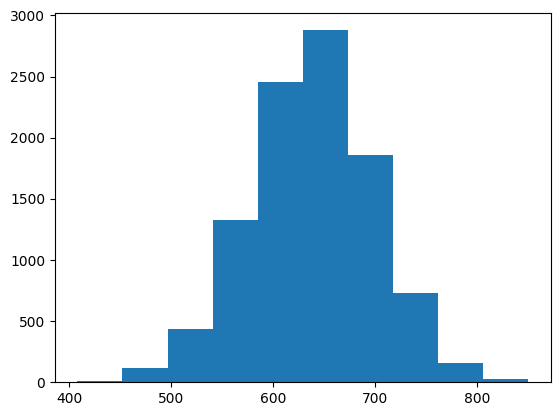

In [3]:
plt.hist(df["fico_score"])

The distribution of FICO scores appears to have a normal distribution as it is not skewed in either directions.

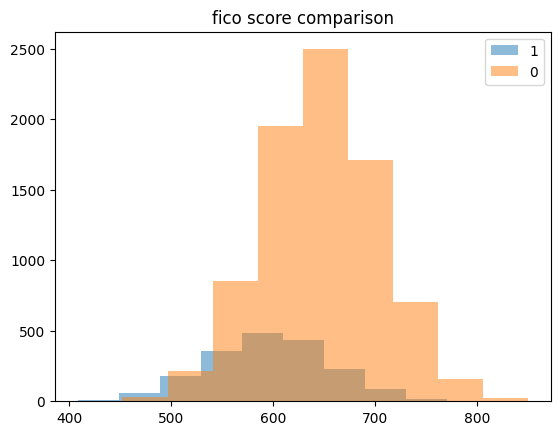

In [4]:
plt.hist(df[df["default"] == 1]["fico_score"], alpha=0.5, label="1")
plt.hist(df[df["default"] == 0]["fico_score"], alpha=0.5, label="0")
plt.legend()
plt.title("fico score comparison")
plt.show()

In [5]:
print(f'Default = 1 FICO score mean: {np.mean(df[df["default"] == 1]["fico_score"])}')
print(f'Default = 0 FICO score mean: {np.mean(df[df["default"] == 0]["fico_score"])}')

Default = 1 FICO score mean: 596.257698541329
Default = 0 FICO score mean: 646.9387654926985


In [6]:
print(f'Default = 1 FICO score standard deviation: {np.std(df[df["default"] == 1]["fico_score"])}')
print(f'Default = 0 FICO score standard deviation: {np.std(df[df["default"] == 0]["fico_score"])}')

Default = 1 FICO score standard deviation: 58.93400276311884
Default = 0 FICO score standard deviation: 57.01155061192385


We can see that the mean FICO score for those who defaulted and those who did not has a difference of around 50 with both having a standard deviation of  around 57~58. Thus, it may also be good to bin the FICO scores by incrementing each bin by the standard deviation.

In [7]:
fico_bins = [0, 580, 669, 739, 799, 851]
names = ["poor", "fair", "good", "very good", "exceptional"]
df["fico_binned"] = pd.cut(df["fico_score"], bins=fico_bins, labels=names)
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,fico_binned
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,fair
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,poor
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,fair
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,fair
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,fair
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,good
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,fair
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,fair
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,fair


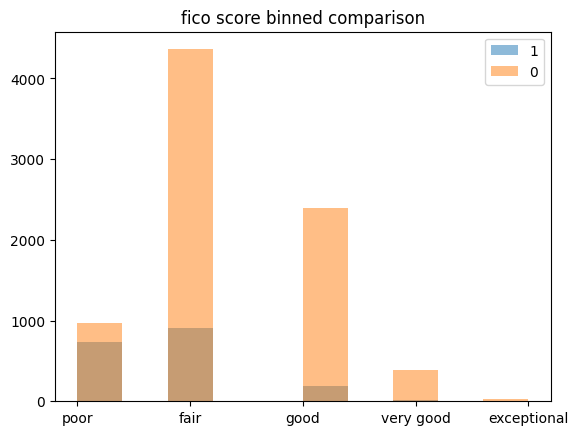

In [8]:
plt.hist(df[df["default"] == 1]["fico_binned"], alpha=0.5, label="1")
plt.hist(df[df["default"] == 0]["fico_binned"], alpha=0.5, label="0")
plt.legend()
plt.title("fico score binned comparison")
plt.show()

I will also create a column representing the debt-income ratio. The rationale is that as those with a higher debt to income ratio will be more likely to default (i.e. they have too much debt and do not make enough to cover the debt).

We can then create bins for this new feature as well by splitting the income ratio into 11 bins from a debt-income ratio of 0 to a debt-income ratio of 1, increnting by 0.1 for each bin.

In [9]:
df["debt_income_ratio"] = df["total_debt_outstanding"] / df["income"]
df["debt_income_ratio_binned"] = pd.cut(df["debt_income_ratio"], bins=np.linspace(0, 1, 11))
df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,fico_binned,debt_income_ratio,debt_income_ratio_binned
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,fair,0.050173,"(0.0, 0.1]"
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,poor,0.308789,"(0.3, 0.4]"
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,fair,0.030787,"(0.0, 0.1]"
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,fair,0.033645,"(0.0, 0.1]"
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,fair,0.075435,"(0.0, 0.1]"
...,...,...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,good,0.059818,"(0.0, 0.1]"
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,fair,0.068253,"(0.0, 0.1]"
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,fair,0.126021,"(0.1, 0.2]"
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,fair,0.020481,"(0.0, 0.1]"


For creating the prediction model this time, we will just assume that we had the binned features already since the problem stated that the model requires categorical data.

In [10]:
PREDICT_COL = "default"
model_df = df[["fico_binned", "debt_income_ratio_binned", PREDICT_COL]]
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=42)
X_train = train_df.drop(columns=[PREDICT_COL])
y_train = train_df[PREDICT_COL]
X_test = test_df.drop(columns=[PREDICT_COL])
y_test = test_df[PREDICT_COL]

In [11]:
X_train["debt_income_ratio_binned"].cat.categories

IntervalIndex([(0.0, 0.1], (0.1, 0.2], (0.2, 0.3], (0.3, 0.4], (0.4, 0.5], (0.5, 0.6], (0.6, 0.7], (0.7, 0.8], (0.8, 0.9], (0.9, 1.0]],
              closed='right',
              dtype='interval[float64]')

We use `OrdinalEncoder` since the categorical features have a sense of "order" in them. For example, "good" is better than "fair".

In [12]:
ordinal_features = ["fico_binned", "debt_income_ratio_binned"]
fico_order = ["poor", "fair", "good", "very good", "exceptional"]
debt_income_ratio_order = X_train["debt_income_ratio_binned"].cat.categories.tolist()
preprocessing_pipeline = Pipeline(steps=[
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('ordinal_feats', OrdinalEncoder(categories=[fico_order, debt_income_ratio_order]), ordinal_features), 
        ]
    ))
])
lr_pipeline = make_pipeline(
    preprocessing_pipeline,
    LogisticRegression(class_weight="balanced")
)

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_feats',
                                                                   OrdinalEncoder(categories=[['poor',
                                                                                               'fair',
                                                                                               'good',
                                                                                               'very '
                                                                                               'good',
                                                                                               'exceptional'],
                                                                                              [Interval(0.0, 0.1, closed='right'),
                                                                          

The model using only categorical features scored 98.2% on the test set, which is slightly lower than the model previously. However, this model should generalize better since it is a simpler model.

In [13]:
lr_pipeline.score(X_test, y_test)

0.982

We can interpret the results by looking at the coefficients the Logistic Regression model has learned.

In [14]:
coefficients = lr_pipeline.named_steps["logisticregression"].coef_[0]
X_test.columns.tolist()
pd.DataFrame({
    "Features": X_train.columns.tolist(),
    "Coefficients": coefficients,
    "Odds Ratio": np.exp(coefficients)
})

,Features,Coefficients,Odds Ratio
0,fico_binned,-1.506342,0.221720
1,debt_income_ratio_binned,6.184446,485.144057


The values for the coefficients represent how changes in the variable impacts the prediction result. A negative value for `fico_binned` means that as we go from "fair" to "good", the log odds of predicting default=1 goes down. The odds ratio suggests that for each order of magnitude increase for `fico_binned`, the odds of predicting default goes down by 4.5 (1/0.22172). In other words, the better a customer's fico score, the less likely the model will predict them to default.

For `debt_income_ratio_binned`, we see that the coefficient is positive, meaning that increases in that feature will increase the log odds of predicting default=1. If we observe the odds ratio for `debt_income_ratio_binned`, we see that for each order of increase, the odds of predicting that the customer defaults increases by 485 times.

Both of these interpretations are in line with our assumptions that: 
1. the better the customer's fico score, the less likely they are to default
2. the higher the customer's debit is to their income, the more likely they are to default